In [5]:
import os
import numpy as np

import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm

In [6]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d 'msambare/fer2013'

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 70% 42.0M/60.3M [00:00<00:00, 221MB/s]
100% 60.3M/60.3M [00:00<00:00, 230MB/s]


In [7]:
import zipfile

zip_file_path = 'fer2013.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('fer-2013')

In [8]:
# Émotions : colère, dégoût, peur, joie, neutre, tristesse, surprise
NB_CLASSES = 7
train_folder_path = 'fer-2013/train'
test_folder_path = 'fer-2013/test'

In [9]:
def get_dataset(path):
    images = []
    labels = []

    for root, _, files in os.walk(path):
        # Nom du sous-dossier correspondant à l'émotion
        _, parent_folder_name = os.path.split(root)

        for filename in tqdm(files):
            image_path = os.path.join(root, filename)
            # Chargement de l'image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                # Ajout de l'image dans images
                images.append(image)
                # Ajout du label dans labels
                labels.append(parent_folder_name)

    return images, labels

In [10]:
# Récupération des images et des labels du jeu d'entraînement
images, labels = get_dataset(train_folder_path)

0it [00:00, ?it/s]
100%|██████████| 3171/3171 [00:00<00:00, 16455.98it/s]


In [11]:
from keras.preprocessing.image import ImageDataGenerator

# Récupération du jeu de test sans augmentation des données
# Seules les valeurs des pixels sont normalisées avec ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

# Chargement des images par lot de 64
test_generator = test_datagen.flow_from_directory(
    test_folder_path,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [12]:
from sklearn.model_selection import train_test_split

# Train set : 80% - validation set : 20%
X_train, X_val, y_train, y_val = train_test_split(np.array(images), np.array(labels), test_size=0.2, random_state=42)

In [13]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encodage des labels en entiers
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_val = le.transform(y_val)

# Encodage One-Hot des labels
y_train = to_categorical(y_train, NB_CLASSES)
y_val = to_categorical(y_val, NB_CLASSES)

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalisation des pixels entre 0 et 1
    rotation_range=15,      # Rotation de l'image entre 0 et 15 degrés
    width_shift_range=0.1,  # Décalage en largeur de 10 % maximum
    height_shift_range=0.1, # Décalage en hauteur de 10 % maximum
    shear_range=0.1,        # Distorsion de l'image
    zoom_range=0.1,         # Zoom dans l'image
    horizontal_flip=True    # Retournement horizontale de l'image
)

In [15]:
# Ajout d'une dimension pour passer X_train dans train_datagen
X_train = np.expand_dims(X_train, axis=-1)

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=64
)

In [16]:
# Pas d'augmentation de données sur l'ensemble de validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Ajout d'une dimension pour passer X_val dans val_datagen
X_val = np.expand_dims(X_val, axis=-1)

val_generator = val_datagen.flow(
    X_val,
    y_val,
    batch_size=64
)

In [17]:
from keras import models, optimizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [18]:
model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(NB_CLASSES, activation='softmax'))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [20]:
from keras.callbacks import ModelCheckpoint

# Instauration d'un checkpoint pour la meilleure valeur de val_accuracy
checkpoint = ModelCheckpoint(
    filepath='checkpoints/model4.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max' # maximisation de l'accuracy sur l'ensemble de validation
)

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint]
)

Epoch 1/60
359/359 [==============================] - ETA: 0s - loss: 2.3952 - accuracy: 0.1895
Epoch 1: val_accuracy improved from -inf to 0.25287, saving model to checkpoints/model4.keras
359/359 [==============================] - 29s 52ms/step - loss: 2.3952 - accuracy: 0.1895 - val_loss: 1.9777 - val_accuracy: 0.2529
Epoch 2/60
359/359 [==============================] - ETA: 0s - loss: 2.1252 - accuracy: 0.2234
Epoch 2: val_accuracy improved from 0.25287 to 0.27778, saving model to checkpoints/model4.keras
359/359 [==============================] - 16s 45ms/step - loss: 2.1252 - accuracy: 0.2234 - val_loss: 1.9217 - val_accuracy: 0.2778
Epoch 3/60
358/359 [============================>.] - ETA: 0s - loss: 2.0277 - accuracy: 0.2398
Epoch 3: val_accuracy improved from 0.27778 to 0.30495, saving model to checkpoints/model4.keras
359/359 [==============================] - 16s 45ms/step - loss: 2.0279 - accuracy: 0.2397 - val_loss: 1.7719 - val_accuracy: 0.3049
Epoch 4/60
358/359 [=====

In [22]:
# Accuracy et loss du train set et validation set pendant l'entraînement
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(history.epoch) + 1)

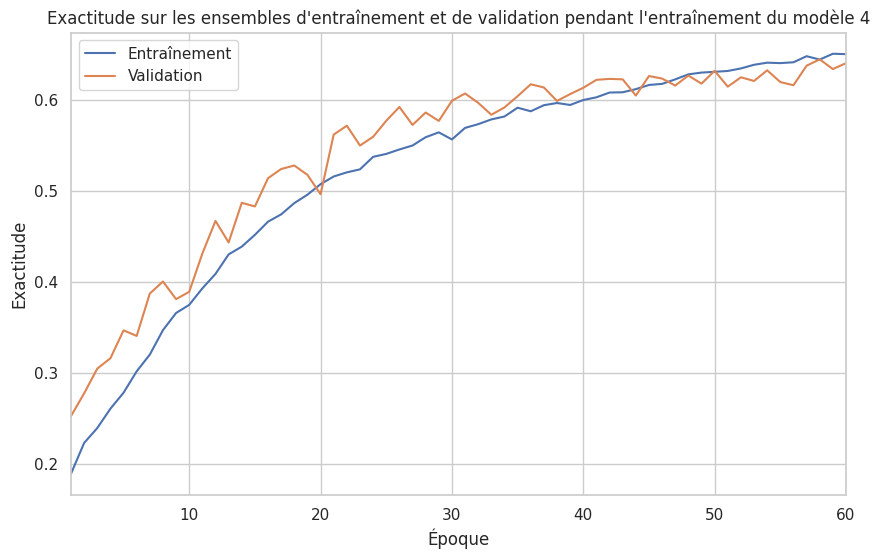

In [25]:
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Entraînement')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Exactitude sur les ensembles d\'entraînement et de validation pendant l\'entraînement du modèle 4')
plt.xlabel('Époque')
plt.ylabel('Exactitude')
plt.legend()
plt.xlim(1, 60)
plt.savefig('accuracy_modele4.png')
plt.show()

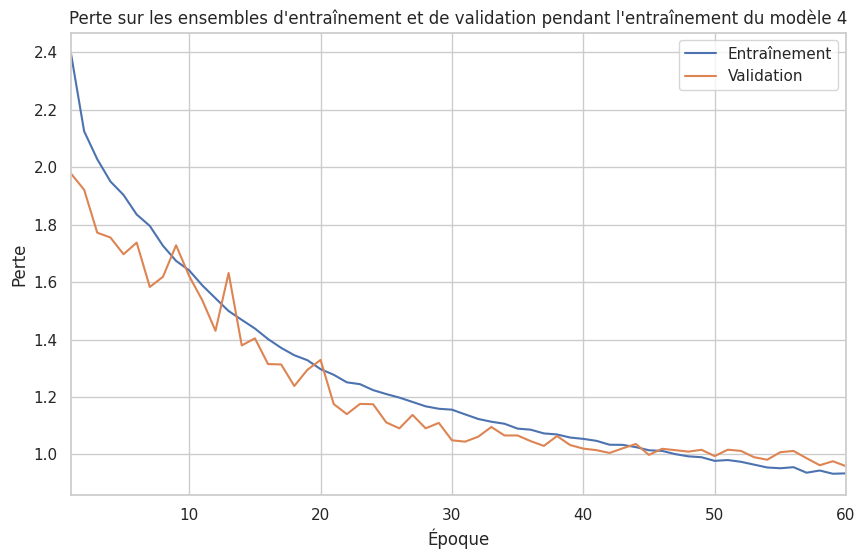

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Entraînement')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Perte sur les ensembles d\'entraînement et de validation pendant l\'entraînement du modèle 4')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.xlim(1, 60)
plt.savefig('loss_modele4.png')
plt.show()

In [27]:
# Évaluation du modèle sur le jeu de test
test_loss, test_acc = model.evaluate(test_generator)

print('Perte sur l\'ensemble de test : ', test_loss)
print('Exactitude sur l\ensemble de test : ', test_acc)

113/113 [==============================] - 5s 44ms/step - loss: 0.9655 - accuracy: 0.6435
Perte sur l'ensemble de test :  0.9655336141586304
Exactitude sur l\ensemble de test :  0.6434940099716187


# Matrice de confusion

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [30]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(test_generator)

113/113 [==============================] - 5s 36ms/step


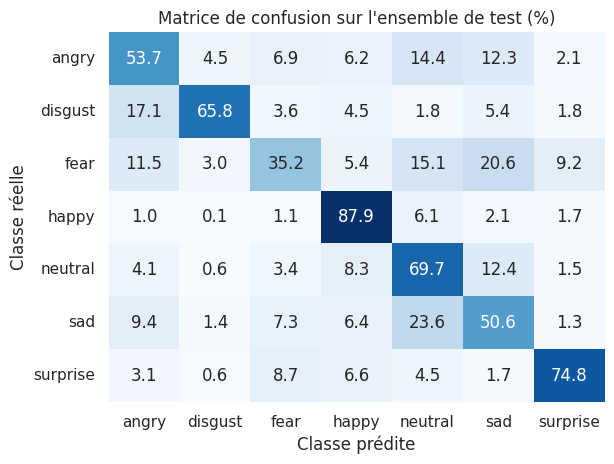

In [39]:
# Récupération de l'indice de la valeur maximale dans chaque vecteur y_pred
y_pred_classes = np.argmax(y_pred, axis=1)
# Récupération des indices des vraies classes
y_true_classes = test_generator.classes

# Les labels ont été encodés dans l'ordre alphabétique : 0=angry, 1=disgust etc.
classes_name = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Construction de la matrice de confusion entre y_test et y_pred
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Matrice de confusion en pourcentage
conf_matrix_sum = np.sum(conf_matrix, axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / conf_matrix_sum.astype(float) * 100

# Affichage de la matrice avec les labels textuels
sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='Blues', cbar=False, xticklabels=classes_name, yticklabels=classes_name)
plt.yticks(rotation=0)
plt.title('Matrice de confusion sur l\'ensemble de test (%)')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.savefig('matrice_confusion_modele4.png')
plt.show()

# Visualisation des filtres

In [40]:
from keras.preprocessing import image

def get_activations(model, layer_name, img_path):
    """
    Récupère les activations d'une couche spécifique pour une image donnée.

    Args:
        model (keras.models.Model) : modèle Keras pré-entraîné.
        layer_name (str) : nom de la couche pour laquelle l'activation va être récupérée.
        img_path (str) : chemin vers l'imation à utiliser pour récupérer les activations.

    Returns:
        numpy.ndarray Tenseur d'activations de la couche spécifique pour l'image donnée.

    """
    layer_index = None

    # Chargement de l'image et redimensionnement
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    # Récupération de l'index de la couche
    for i, layer in enumerate(model.layers):
        if layer.name == layer_name:
            layer_index = i
            break

    # Récupération des sorties do modèle pour la couche layer_name avec l'image img
    activation_model = models.Model(inputs=model.input, outputs=model.layers[layer_index].output)
    activations = activation_model.predict(img)

    return activations

In [41]:
def predict_emotion(model, image_path):
    """
    Prédit l'émotion d'une image selon le modèle fourni.

    Args:
        model (keras.models.Model) : modèle Keras pré-entraîné.
        image_path (str) : chemin vers l'image dont on veut prédire l'émotion.

    Returns:
        Tuple (int, str, ndarray)
            indice de l'émotion prédite
            nom de l'émotion prédite
            tenseur contenant les scores de prédiction des émotions
    """

    # Chargement de l'image et redimensionnement
    img = image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    # Prédiction du modèle sur l'image
    emotion_scores = model.predict(img)

    # Récupération de l'indice de la valeur la plus élevée dans le vecteur de prédiction
    predicted_emotion_index = np.argmax(emotion_scores)

    # Récupération du nom de l'émotion
    predicted_emotion_label = classes_name[predicted_emotion_index]

    return predicted_emotion_index, predicted_emotion_label, emotion_scores

In [42]:
def show_filters(activations, n_rows, n_cols, fig_width, fig_height, save=''):
    """
    Affiche les filtres convolutifs sous forme de grille.

    Args:
        activations (numpy.ndarray) : tenseur d'activations de dimension (1, hauteur, largeur, n_filtres).
        n_rows (int) : nombre de lignes dans la grille.
        n_cols (int) : nombre de colonnes dans la grille.
        fig_width (int) : largeur de la figure.
        fig_height (int) : hauteur de la figure.
        save (str) optional : nom du fichier pour sauvegarder l'image. Si rien n'est spécifié l'image n'est pas sauvegardée.

    Returns:
        None
    """
    plt.figure(figsize=(fig_width, fig_height))
    for i in range(activations.shape[3]):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(activations[0, :, :, i], cmap='viridis')
        plt.axis('off')

    if save:
        plt.savefig(save)

    plt.show()

In [43]:
# Deux images prises dans l'ensemble de test
surprise_img_path = 'fer-2013/test/surprise/PublicTest_7431524.jpg'
happy_img_path = 'fer-2013/test/happy/PrivateTest_928647.jpg'

## Prédiction et visualisation des filtres pour la surprise

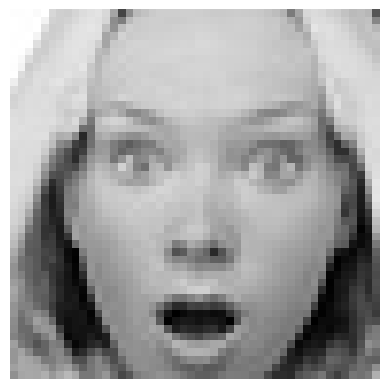

In [44]:
# Test des filtres sur une image prise dans l'ensemble de test pour l'émotion surprise
surprise_img = image.load_img(surprise_img_path, target_size=(48, 48))
plt.imshow(surprise_img)
plt.axis('off')
plt.show()

In [45]:
predicted_index_sur, predicted_label_sur, scores_sur = predict_emotion(model, surprise_img_path)
print(f"Emotion prédite : {predicted_label_sur} avec probabilité {scores_sur[0][predicted_index_sur]}")
print(f"Scores d'émotions : {np.round(scores_sur, 3)}")

1/1 [==============================] - 1s 509ms/step
Emotion prédite : surprise avec probabilité 0.9961652755737305
Scores d'émotions : [[0.001 0.    0.003 0.    0.    0.    0.996]]


1/1 [==============================] - 0s 66ms/step
(1, 48, 48, 32)


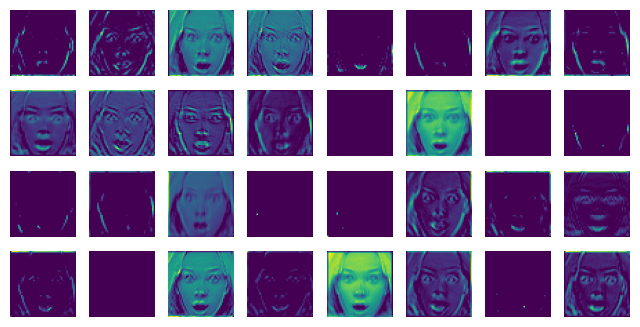

In [47]:
act_sur_4_layer_1 = get_activations(model, 'conv2d', surprise_img_path)

print(act_sur_4_layer_1.shape)
show_filters(activations=act_sur_4_layer_1, n_rows=4, n_cols=8, fig_width=8, fig_height=4,
             save='filtres_modele4_conv2d_surprise_PublicTest_7431524.png')

1/1 [==============================] - 0s 52ms/step
(1, 48, 48, 64)


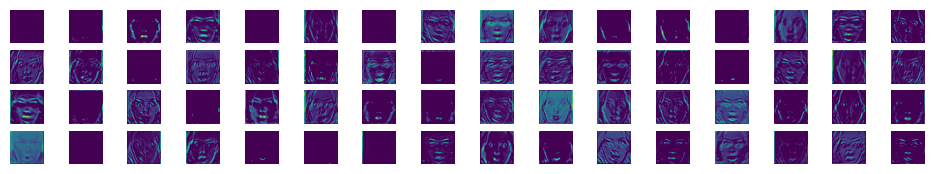

In [49]:
act_sur_4_layer_2 = get_activations(model, 'conv2d_1', surprise_img_path)

print(act_sur_4_layer_2.shape)
show_filters(activations=act_sur_4_layer_2, n_rows=4, n_cols=16, fig_width=12, fig_height=2,
             save='filtres_modele4_conv2d_1_surprise_PublicTest_7431524.png')

1/1 [==============================] - 0s 90ms/step
(1, 24, 24, 128)


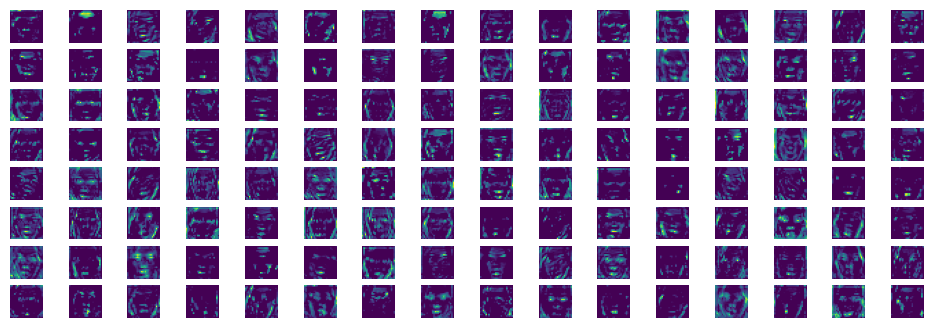

In [51]:
act_sur_4_layer_3 = get_activations(model, 'conv2d_2', surprise_img_path)

print(act_sur_4_layer_3.shape)
show_filters(activations=act_sur_4_layer_3, n_rows=8, n_cols=16, fig_width=12, fig_height=4,
             save='filtres_modele4_conv2d_2_surprise_PublicTest_7431524.png')

## Prédiction et visualisation des filtres pour la joie

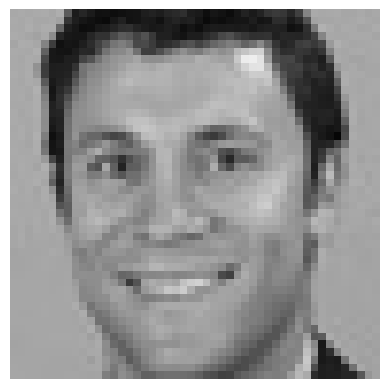

In [52]:
# Test des filtres sur une image prise dans l'ensemble de test pour l'émotion joie
happy_img = image.load_img(happy_img_path, target_size=(48, 48))
plt.imshow(happy_img)
plt.axis('off')
plt.show()

In [53]:
predicted_index_hap, predicted_label_hap, scores_hap = predict_emotion(model, happy_img_path)
print(f"Emotion prédite : {predicted_label_hap} avec probabilité {scores_hap[0][predicted_index_hap]}")
print(f"Scores d'émotions : {np.round(scores_hap, 3)}")

1/1 [==============================] - 0s 41ms/step
Emotion prédite : happy avec probabilité 0.9857564568519592
Scores d'émotions : [[0.    0.    0.    0.986 0.013 0.    0.001]]


1/1 [==============================] - 0s 103ms/step
(1, 48, 48, 32)


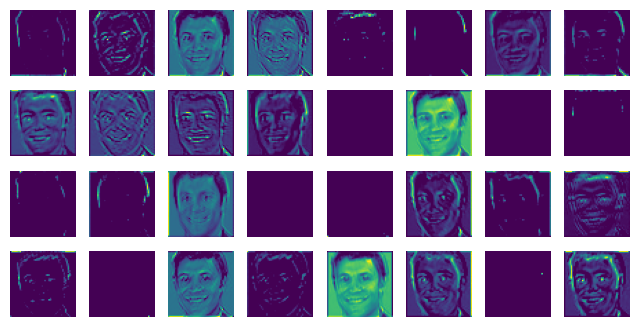

In [54]:
act_hap_4_layer_1 = get_activations(model, 'conv2d', happy_img_path)

print(act_hap_4_layer_1.shape)
show_filters(activations=act_hap_4_layer_1, n_rows=4, n_cols=8, fig_width=8, fig_height=4,
             save='filtres_modele4_conv2d_happy_PrivateTest_928647.png')

1/1 [==============================] - 0s 74ms/step
(1, 48, 48, 64)


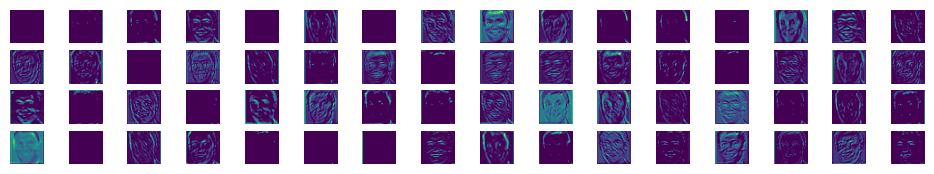

In [55]:
act_hap_4_layer_2 = get_activations(model, 'conv2d_1', happy_img_path)

print(act_hap_4_layer_2.shape)
show_filters(activations=act_hap_4_layer_2, n_rows=4, n_cols=16, fig_width=12, fig_height=2,
             save='filtres_modele4_conv2d_1_happy_PrivateTest_928647.png')

1/1 [==============================] - 0s 98ms/step
(1, 24, 24, 128)


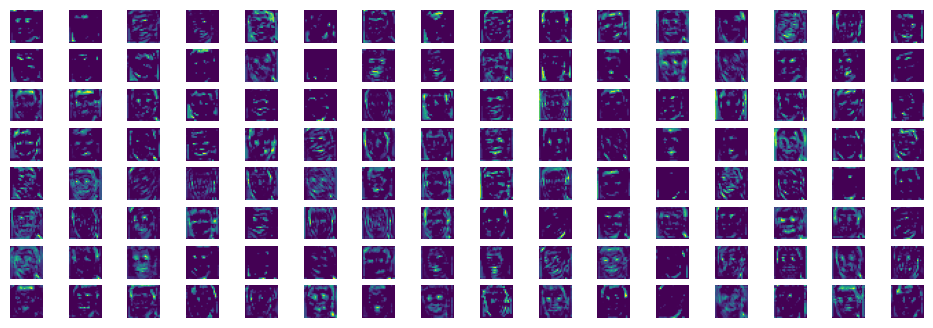

In [56]:
act_hap_4_layer_3 = get_activations(model, 'conv2d_2', happy_img_path)

print(act_hap_4_layer_3.shape)
show_filters(activations=act_hap_4_layer_3, n_rows=8, n_cols=16, fig_width=12, fig_height=4,
             save='filtres_modele4_conv2d_2_happy_PrivateTest_928647.png')